### To dos
- check skew of variables
    - apply transformations as required
- convert categoricals to dummy variables
- deal with nulls/nans (or don't)
- split off dependent/independent variables
- scale/normalise
- split into train/validate


Let's start off with some imports

In [126]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

We'll then load up the training data and derive a list of numerical and categorical features

In [111]:
train = pd.read_csv("../data/train.csv")

numeric = [var for var in train.columns if train.dtypes[var] != 'object']
category = [var for var in train.columns if train.dtypes[var] == 'object']

Now let's analyse our null values, by feature type

In [115]:
num_nulls = train[numeric].isnull().sum().sort_values(ascending=False)
print("Numerical features with null values:\n{}".format(num_nulls[num_nulls > 0]))

print()

cat_nulls = train[category].isnull().sum().sort_values(ascending=False)
print("Categorical features with null values:\n{}".format(cat_nulls[cat_nulls > 0]))


# nulls = train.isnull().sum()
# nulls = nulls[nulls > 0]
# nulls = nulls.reset_index()
# nulls.columns = ['variable', 'count']
# nulls['percent'] = nulls['count'] / len(train)
# nulls.sort_values("count", ascending=False, inplace=True)
# nulls

Numerical features with null values:
LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

Categorical features with null values:
PoolQC          1452
MiscFeature     1405
Alley           1368
Fence           1178
FireplaceQu      689
GarageType        81
GarageCond        81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrType         8
dtype: int64


Numerical features with null values should be replaceable with zeros. For the categoricals, we need to dig a little deeper.

`PoolQC`, `MiscFeature`, `Alley`, `Fence`, and `FireplaceQu` all have ~50% or more missing values. Let's check in turn if we should drop the variable or convert it to a dummy.

The `Garage*`, `Bsmt*`, and `MsnVnr*` variables each sharing the same values would indicate these nulls communicate an absence of that feature. We can capture this with a dummy variable which we create later

In [84]:
high_null = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
for feat in high_null:
    print(train[feat].unique())

[nan 'Ex' 'Fa' 'Gd']
[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'Grvl' 'Pave']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In my estimation, `PoolQC` is probably covered adequately 
by the `PoolArea` feature; ditto `FireplaceQu` & `Fireplaces`; 
`MiscFeature`, with so many null values is unlikely to add value.

We will delete these three, and convert the other two into 
dummy variables representing yes/no for 'has fence' and 'has alley'

In [59]:
if len(train.columns) == 81:
    train = train.drop(['PoolQC', 'MiscFeature', "FireplaceQu"], axis=1)

Before we create our dummy variables, let's look at the last null value we haven't address: Electrical. Given that there is just one of entry, let's drop the data point with no electrical (how does that work anyway?)

In [114]:
print(train[train["Electrical"].isna() == True]["Electrical"])
if len(train) == 1460:
    train.drop(1379, inplace=True)


Series([], Name: Electrical, dtype: object)


Let's make those dummy variables. We will utilise the `pandas` built-in `get_dummies()`. Using this function, we capture natively the houses without garages, pools, etc. as entries with 0s for all the categorical options for a given variable. 

To address this on the numerical variable side, we will `fillna` with 0s

In [145]:
categoricals = pd.get_dummies(train[category])
numericals = train[numeric].fillna(0)
dataset = pd.merge(numericals, categoricals, left_index=True, right_index=True)
dataset

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,...,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,

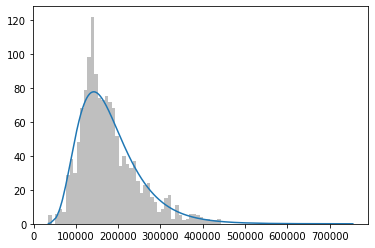

In [27]:

# y = train['SalePrice'].sort_values()
# # x = np.arange(len(y))
# # fig, ax = plt.subplots(1,2)
# # plt.figure(1); plt.title('Johnson SU')
# # sns.displot(y)

# number_of_bins = 50
# bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)
# h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# # Create the plot
# # sns.displot(y)
# params = st.lognorm.fit(y)
# # print(params)

# fitted_pdf = st.lognorm.pdf(y, params[0], loc=params[-2], scale=params[-1])
# scale_pdf = np.trapz(h[0], h[1][:-1]) / np.trapz(fitted_pdf, y)
# fitted_pdf *= scale_pdf
# # sns.lineplot(x=y, y=fitted_pdf)
# plt.plot(y, fitted_pdf)
# # sns.displot(y)
# # plt.figure(2); plt.title('Normal')
# # sns.distplot(y, kde=False, fit=st.norm)
# # plt.figure(3); plt.title('Log Normal')
# # sns.distplot(y, kde=False, fit=st.lognorm)